# Toy Distributions for L2HMC

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import setup_directories, train_dynamics
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.generic_network import GenericNetwork
from config import (State, NetWeights, MonteCarloStates,
                    DynamicsConfig, NetworkConfig, lrConfig,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2020-08-31 13:38:15,821:INFO:Number of devices: 1


## Helper functions

In [15]:
def identity(x):
    return x

def get_dynamics(flags):
    """Return `GenericDynamics` object, initialized from `flags`."""
    config = DynamicsConfig(eps=flags.eps,
                            num_steps=flags.num_steps,
                            hmc=flags.hmc,
                            eps_trainable=flags.eps_trainable,
                            model_type=flags.model_type)


    net_config = NetworkConfig(units=flags.units,
                               dropout_prob=flags.dropout_prob,
                               name=flags.network_name,
                               activation_fn=flags.activation_fn)

    lr_config = lrConfig(flags.lr_init,
                         decay_steps=flags.decay_steps,
                         decay_rate=flags.decay_rate,
                         warmup_steps=flags.warmup_steps)

    dynamics = GenericDynamics(params=flags,
                               config=config,
                               lr_config=lr_config,
                               normalizer=identity,
                               network_config=net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
    
    return dynamics

In [16]:
import utils.file_io as io
from utils.distributions import contour_potential

%matplotlib inline

def plot_chains(dirs, x_arr, potential_fn, label=None, cmap='rainbow'):
    figs_dir = os.path.join(dirs.log_dir, 'figures')
    io.check_else_make_dir(figs_dir)

    x_arr = tf.convert_to_tensor(x_arr).numpy()

    for chain in range(4):
        fig, ax = plt.subplots()
        xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
        #sns.kdeplot(*xy, ax=ax)
        #grid = xy.reshape(2, -1).T
        #Z = np.exp(-POTENTIAL_FN(grid))
        #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
        #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
        #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
        xlim = 5
        ylim = 5
        _ = contour_potential(POTENTIAL_FN, ax=ax, cmap='rainbow', xlim=xlim, ylim=ylim)
        _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                    color='white', label='l2hmc samples')
        #_ = ax.legend(markerscale=5., loc='best')
        _ = ax.set_xlim((-xlim, xlim))
        _ = ax.set_ylim((-ylim, ylim))
        out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.show()

In [17]:
def plot_density_estimation(potential_fn, x_l2hmc, x_hmc,
                            title=None, cmap=None, num_plots=5):
    def _format_arr(x):
        x = np.array(x)
        n = x.shape[0]
        therm = 2 * n // 10  # Drop first 20% of samples (thermalization)
        return x[therm:]
    
    x_l2hmc = _format_arr(x_l2hmc)
    x_hmc = _format_arr(x_hmc)
    
    for idx in range(num_plots):
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
        _ = contour_potential(potential_fn, title=title, ax=axes[0], cmap=cmap)
        _ = sns.kdeplot(x_l2hmc[:, idx, 0], x_l2hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[1])
        _ = sns.kdeplot(x_hmc[:, idx, 0], x_hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[2])
        _ = axes[1].set_title('L2HMC samples')
        _ = axes[2].set_title('HMC samples')
        plt.tight_layout()
        
    return fig, axes

### Plot examples of (toy) target distributions:

In [2]:
%matplotlib inline

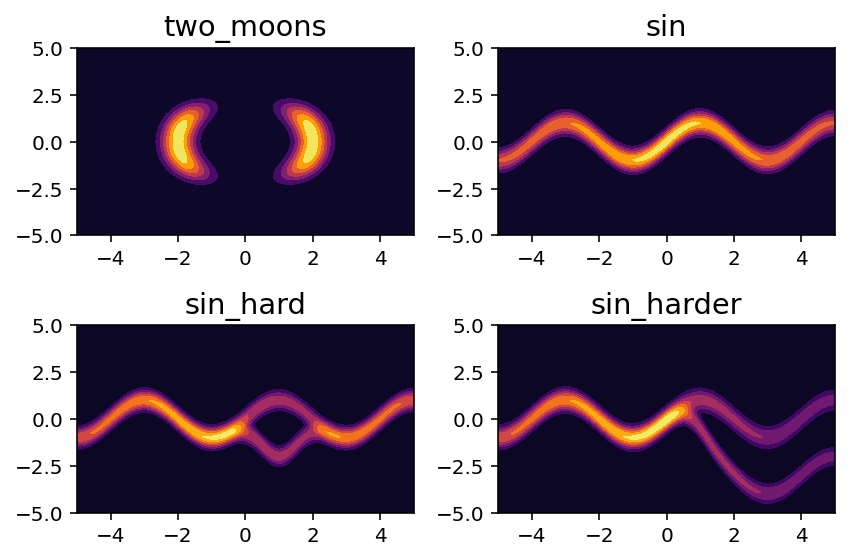

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons', 'sin', 'sin_hard', 'sin_harder']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
potentials_dict = {}
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}')
    potentials_dict[names[idx]] = p_fn
plt.show()

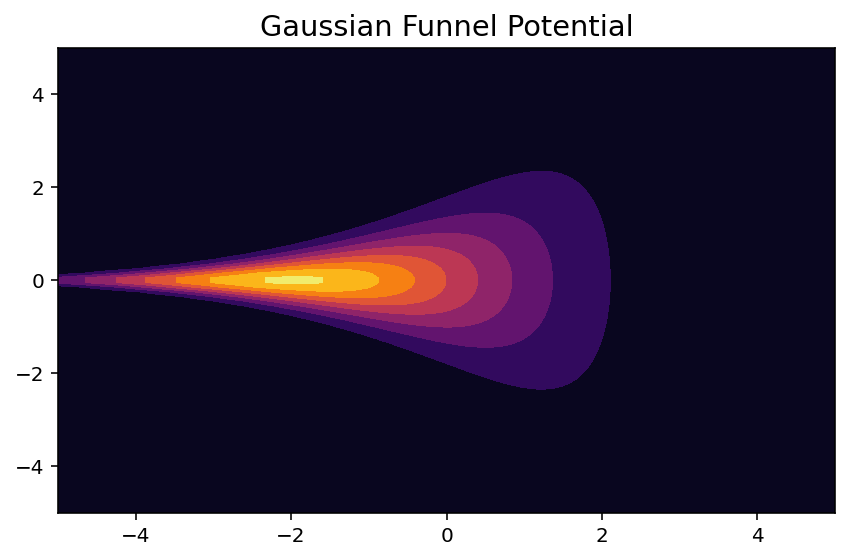

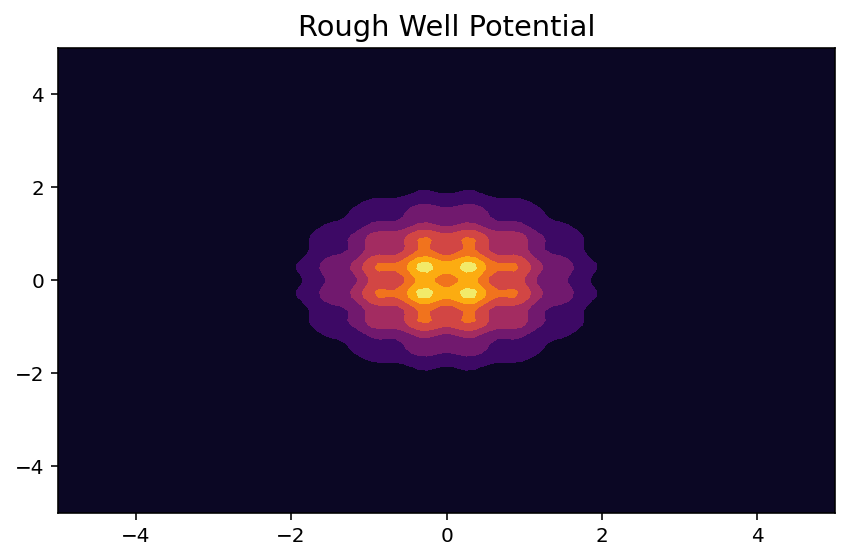

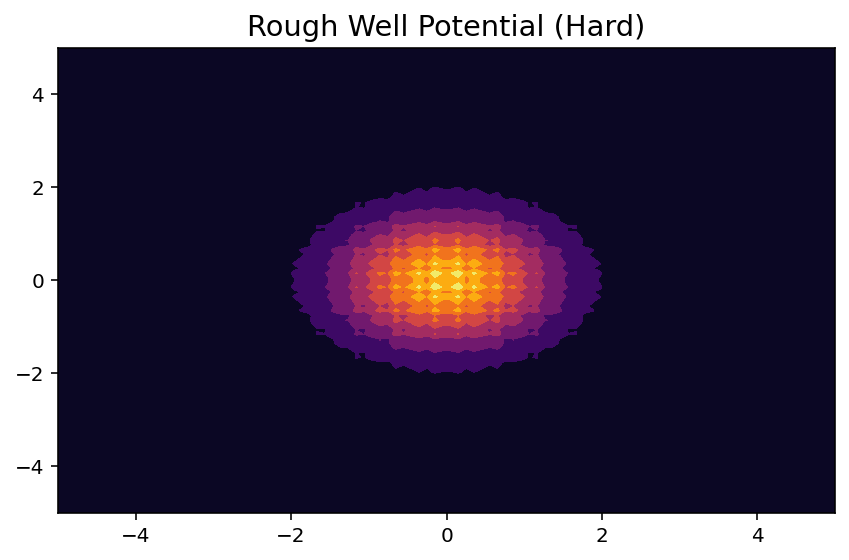

In [4]:
from utils.distributions import GaussianFunnel, RoughWell

funnel = GaussianFunnel()
funnel_potential = funnel.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(funnel_potential, ax=ax, title=f'Gaussian Funnel Potential')
plt.show()

rough_well = RoughWell(dim=2, eps=0.1, easy=True)
rw_potential = rough_well.get_energy_function()

fig, ax = plt.subplots()
_ = contour_potential(rw_potential, ax=ax, title=f'Rough Well Potential')
plt.show()

rough_well_hard = RoughWell(dim=2, eps=0.1, easy=False)
rwh_potential = rough_well_hard.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(rwh_potential, ax=ax, title=f'Rough Well Potential (Hard)')
plt.show()

potentials_dict.update({
    'funnel': funnel_potential,
    'rough_well': rw_potential,
    'rough_well_hard': rwh_potential,
})

## Define parameters of the model and target distribution

In [5]:
import datetime

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE = 'two_moons'
POTENTIAL_FN = potentials_dict[MODEL_TYPE]

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')
log_dir = os.path.join(BASE_DIR, MODEL_TYPE, date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)


flags = AttrDict({
    'restore': False,
    'horovod': False,
    'profiler': False,
    'xdim': 2,
    'eps': 0.1,
    'batch_size': 512,
    'num_steps': 10,
    'beta_init': 1.,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 0,
    'lr_init': 1e-3,
    'train_steps': 10000,
    'clip_value': 0.,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 250,
    'warmup_steps': 0,
    'print_steps': 100,
    'units': [100, 100],
    'hmc': False,
    'eps_trainable': True,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.0,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

## Train

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [6]:
flags.hmc_steps = 10000

x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = lrConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict(dict(flags))
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 10000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_trainable=flags.eps_trainable,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    flags.eps = hmc_dynamics.eps.numpy()

2020-08-31 13:59:11,333:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31
2020-08-31 13:59:11,334:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training_hmc
2020-08-31 13:59:11,334:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training_hmc/train_data
2020-08-31 13:59:11,335:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training_hmc/checkpoints
2020-08-31 13:59:11,336:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training_hmc/summaries
2020-08-31 13:59:11,336:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training_hmc/dynamics_configs
2020-08-31 13:59:11,338:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training_hmc/FLAGS.z.
2020-08-31 13:59:11,348:INFO:************************************************************************************************************************
2020-08-31 13:59:21,852:INFO:Compiled `dynami

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000   0.02021      -4.531      0.991       0.1013        1           0      
   100/10000    0.0185      3.764       0.9983      0.1042        1           0      
   200/10000   0.01625      1.779       0.9964      0.1161        1           0      
   300/10000   0.01603      7.633       0.9978      0.1097        1           0      
   400/10000   0.01931      3.773       0.9979      0.1075        1           0      
   500/10000   0.01634      3.072       0.9926      0.1276        1           0      
   600/10000   0.01792      2.985       0.986       0.145         1           0      
   700/10000   0.01768      1.487       0.9825      0.1572        1           0      
   800/10000   0.01659      2.324       0.9856      0.148

  9000/10000   0.02236      0.6518      0.9949      0.1201        1           0      
  9100/10000   0.02229      2.782       0.994       0.127         1           0      
  9200/10000   0.02148      5.951       0.9913      0.1325        1           0      
  9300/10000   0.02435        8         0.986       0.1423        1           0      
  9400/10000   0.02499      2.454       0.9888      0.1348        1           0      
  9500/10000   0.02882      4.929       0.9892      0.1457        1           0      
  9600/10000    0.0278       1.73       0.9855      0.1407        1           0      
  9700/10000   0.02684      2.331       0.9852      0.1486        1           0      
  9800/10000   0.03114      2.548       0.9868      0.1461        1           0      
  9900/10000   0.03723      2.318       0.9861      0.1582        1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

In [7]:
flags.eps = hmc_dynamics.eps.numpy()

### Create `GenericDynamics` object

In [9]:
dynamics = get_dynamics(flags)

### Train L2HMC sampler using HMC sampler as starting point

In [10]:
dirs = setup_directories(flags)
flags.train_steps = 20000
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-08-31 14:08:00,360:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training
2020-08-31 14:08:00,361:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training/train_data
2020-08-31 14:08:00,362:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training/checkpoints
2020-08-31 14:08:00,363:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training/summaries
2020-08-31 14:08:00,363:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training/dynamics_configs
2020-08-31 14:08:00,365:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training/FLAGS.z.
2020-08-31 14:08:00,374:INFO:************************************************************************************************************************
2020-08-31 14:08:13,829:INFO:Compiled `dynamics.train_step` using tf.function!
2020-08-31 14:08:13,830:INFO:*********************************************************

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/20000   0.04038      7.102       0.8787      0.164         1       -0.001703  
   100/20000   0.03951      2.316       0.645       0.1617        1        0.008007  
   200/20000   0.04135      11.88       0.6213      0.1667        1        0.004115  
   300/20000   0.03976      6.131       0.6248      0.166         1        0.002283  
   400/20000   0.04675      4.235       0.6045      0.1718        1        0.004893  
   500/20000   0.05183      5.899       0.6954      0.1679        1       -0.002688  
   600/20000   0.06182      6.093       0.6424      0.1599        1        0.002782  
   700/20000   0.06153      4.607       0.6571      0.1625        1       -0.0001759 
   800/20000   0.06429      2.182       0.7182      0.164

  9000/20000    0.1177      7.132       0.5848      0.1275        1       -0.0009676 
  9100/20000   0.09995      29.83       0.7441      0.1226        1       0.0002237  
  9200/20000    0.1123      2.797       0.6479      0.1269        1       0.0003193  
  9300/20000   0.08471      2.333       0.6555      0.1278        1        0.003899  
  9400/20000   0.07655      23.68       0.7601      0.1315        1       0.0002345  
  9500/20000   0.08786      3.121       0.7382      0.1477        1       -0.002651  
  9600/20000    0.0811      4.824       0.7093      0.1365        1       -0.003091  
  9700/20000   0.08558      2.672       0.558       0.1421        1        -0.00162  
  9800/20000   0.07756      1.121       0.5707      0.1421        1        0.001723  
  9900/20000   0.08907      3.375       0.548       0.1343        1       -0.0003666 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

 18000/20000   0.09441      0.974       0.7611      0.1014        1       0.0003026  
 18100/20000   0.08756      3.274       0.7684      0.1002        1       -0.0007314 
 18200/20000    0.248       1.837       0.7518      0.1019        1        0.002288  
 18300/20000   0.09857       1.5        0.7692     0.09408        1       0.0004224  
 18400/20000   0.08976      4.529       0.7805     0.08239        1        0.001197  
 18500/20000    0.119       3.142       0.7614     0.07468        1       -0.0004442 
 18600/20000   0.09799      10.68       0.7823      0.0651        1        0.001054  
 18700/20000    0.1067      3.289       0.7595      0.0593        1        0.001813  
 18800/20000   0.09337      13.23       0.7654     0.06147        1       0.0008489  
 18900/20000    0.1037      12.03       0.7989     0.05541        1       -0.002564  
 19000/20000    0.1056      7.265       0.7859     0.06054        1       0.0007517  
 19100/20000    0.1021      3.224       0.7455      0.

## Run inference

In [11]:
import utils.file_io as io

dirs = setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-08-31 14:38:14,758:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training/FLAGS.z.
2020-08-31 14:38:14,764:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/training/checkpoints/ckpt-21


In [12]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-08-31 14:38:21,185:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/inference/summaries
2020-08-31 14:38:21,189:INFO:Running inference with:
 beta: 1.0
eps: 0.04567
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.02645      5.421       0.762      0.04567        1        0.001333  
   100/5000    0.02006      6.317       0.7686     0.04567        1       -0.0007942 
   200/5000     0.0215      22.23       0.7807     0.04567        1       0.0007848  
   300/5000    0.02122      5.687       0.7693     0.04567        1       -0.0006446 
   400/5000    0.02056      6.034       0.7714     0.04567        1       -0.001326  
   500/5000    0.02065      29.08       0.7849     0.04567        1       0.0002855  
   600/5000    0.02604      4.146       0.7674     0.04567        1       -0.001537  
   700/5000    0.02123      5.533       0.7871     0.04567        1       -0.001271  
   800/5000     0.0207      4.721       0.7691     0.04567        1       0.0001655  
   900/5000    0.02131      4.419       0.7858     0.04567        1       -0.0005039 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

In [13]:
summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000
if flags.hmc_steps > 0:
    run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True)
    
writer_hmc.flush()
writer_hmc.close()

2020-08-31 14:40:59,047:INFO:Running inference with:
 beta: 1.0
eps: 0.162
net_weights: NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.008658     0.1988      0.9813      0.162         1           0      
   100/5000    0.00698      1.858       0.9836      0.162         1           0      
   200/5000    0.007628     0.8344      0.9834      0.162         1           0      
   300/5000    0.006303     1.479       0.9824      0.162         1           0      
   400/5000    0.007793     5.189       0.9838      0.162         1           0      
   500/5000    0.00769      1.747       0.9806      0.162         1           0      
   600/5000    0.008863     2.551       0.9806      0.162         1           0      
   700/5000    0.007758     1.699       0.9807      0.162         1           0      
   800/5000    0.006284     2.336       0.9819      0.162         1           0      
   900/5000    0.006873     0.6148      0.9822      0.162         1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

In [ ]:
plt.colormaps()

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1065ff6890>,
       dtype=object))

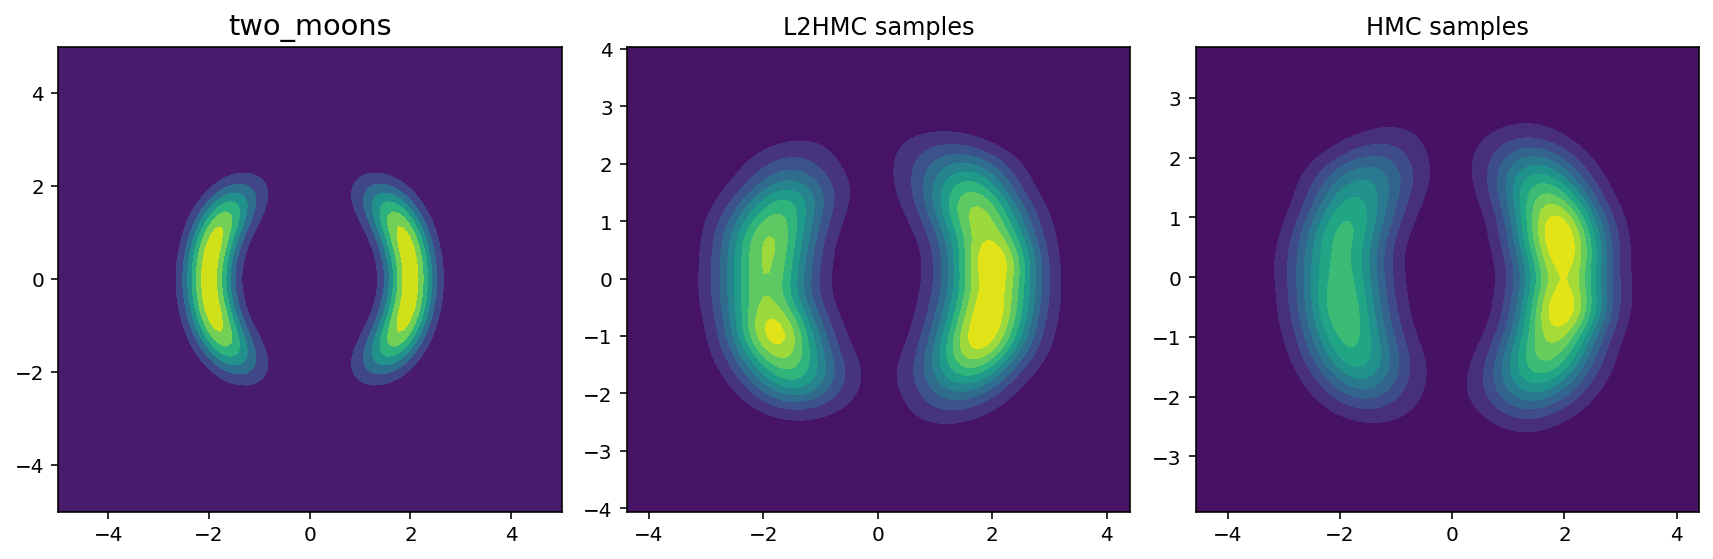

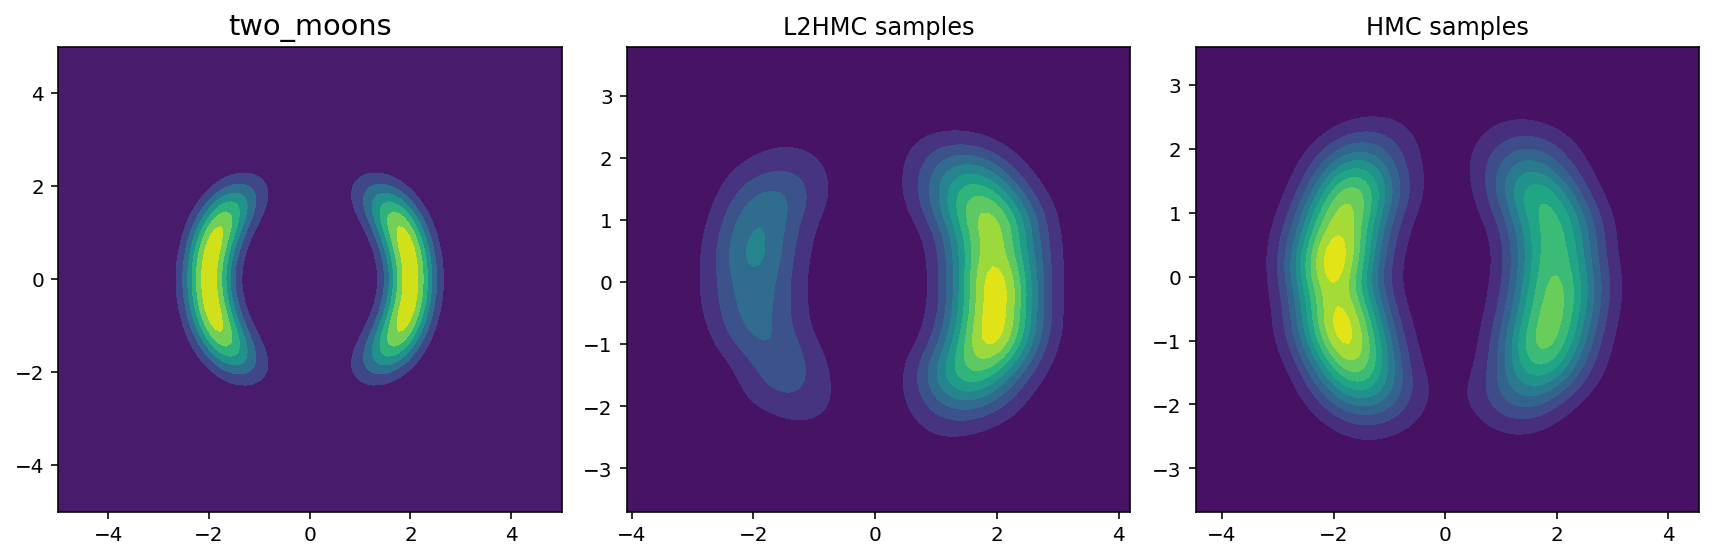

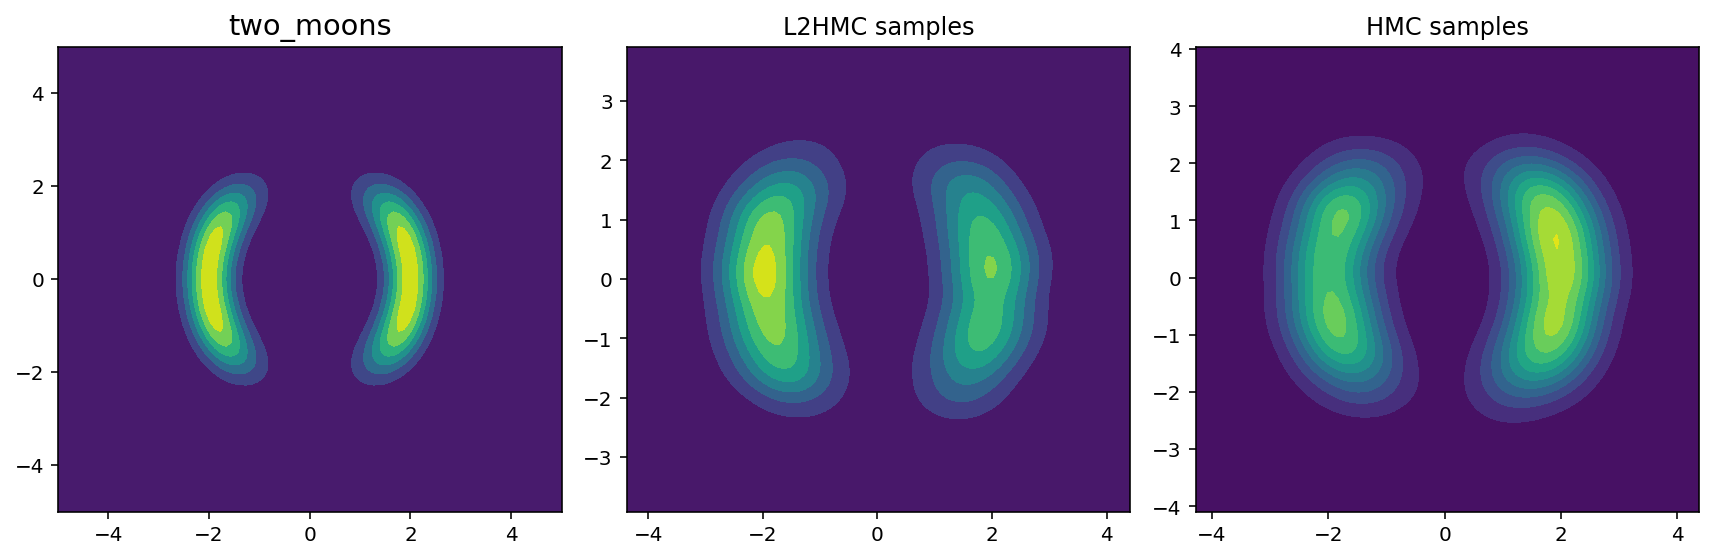

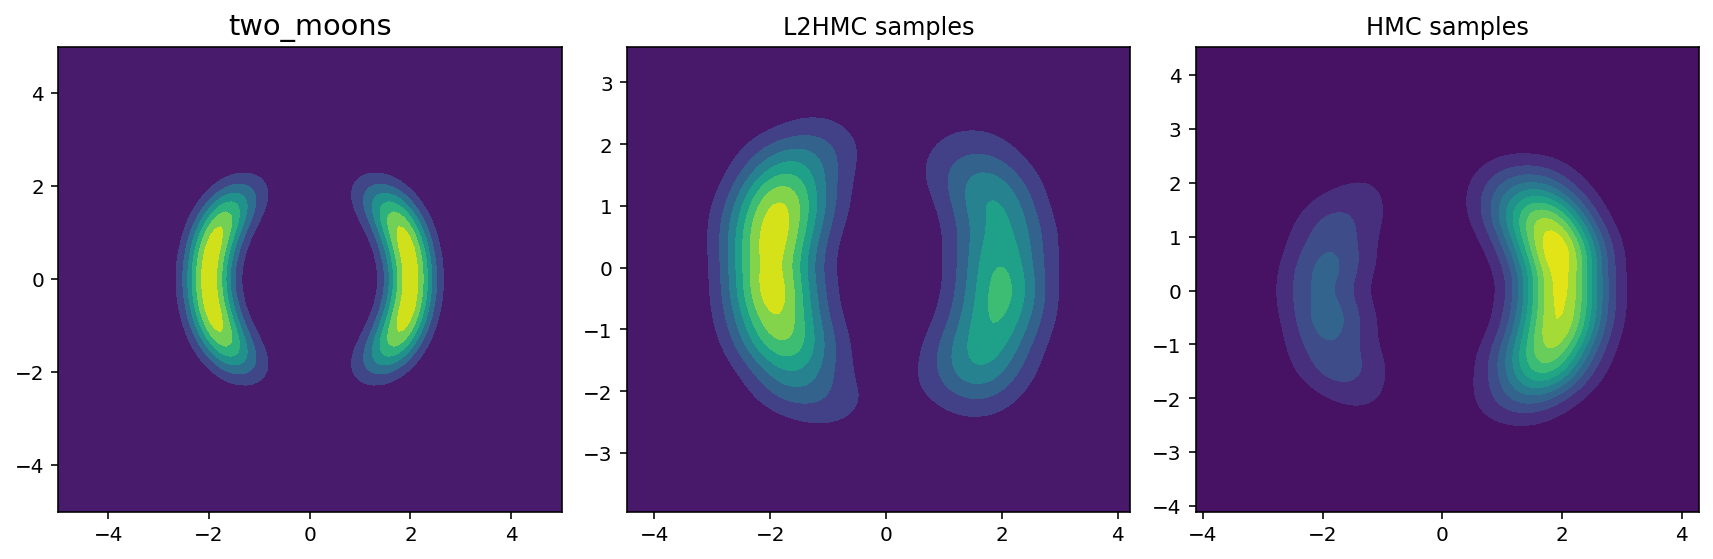

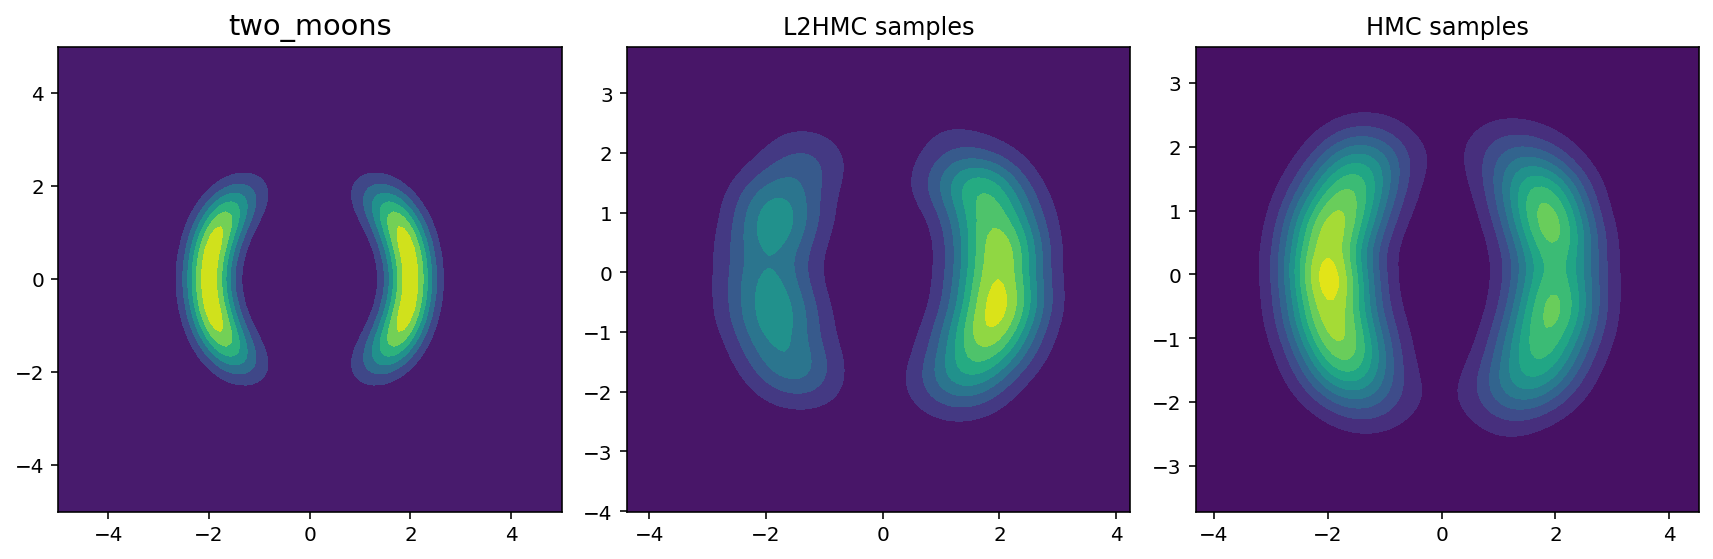

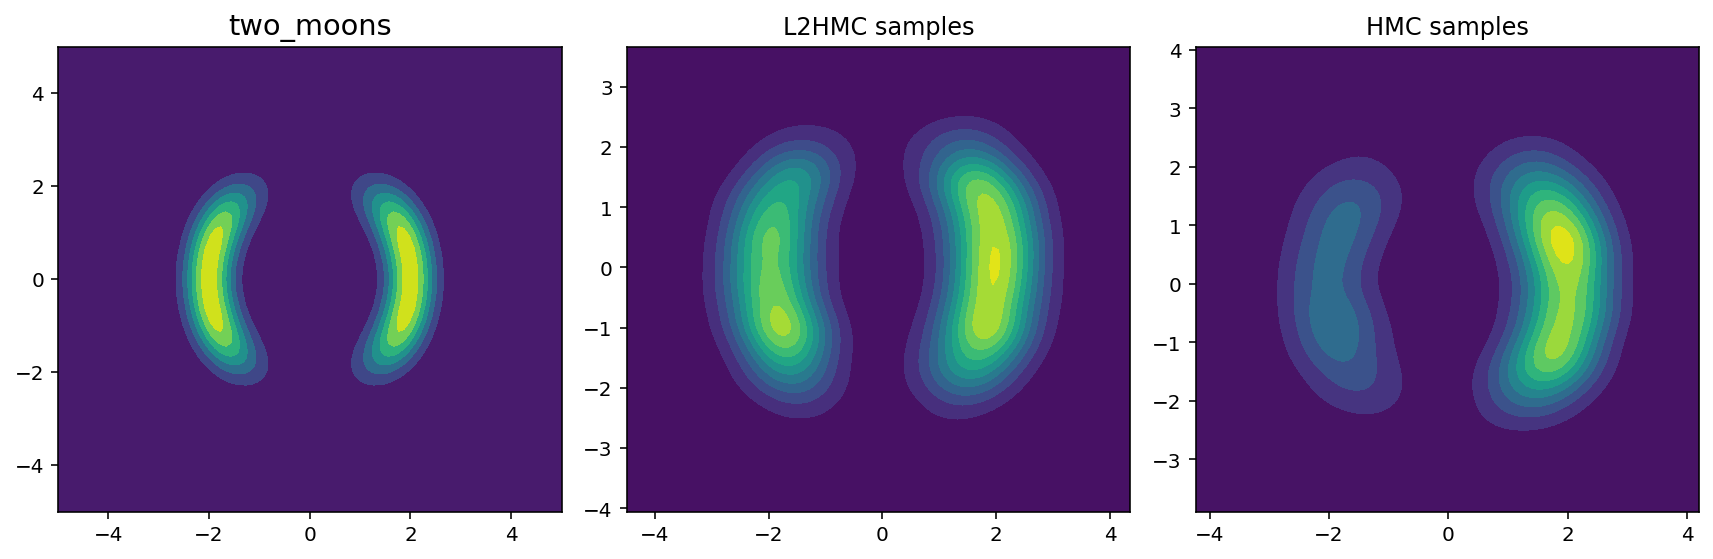

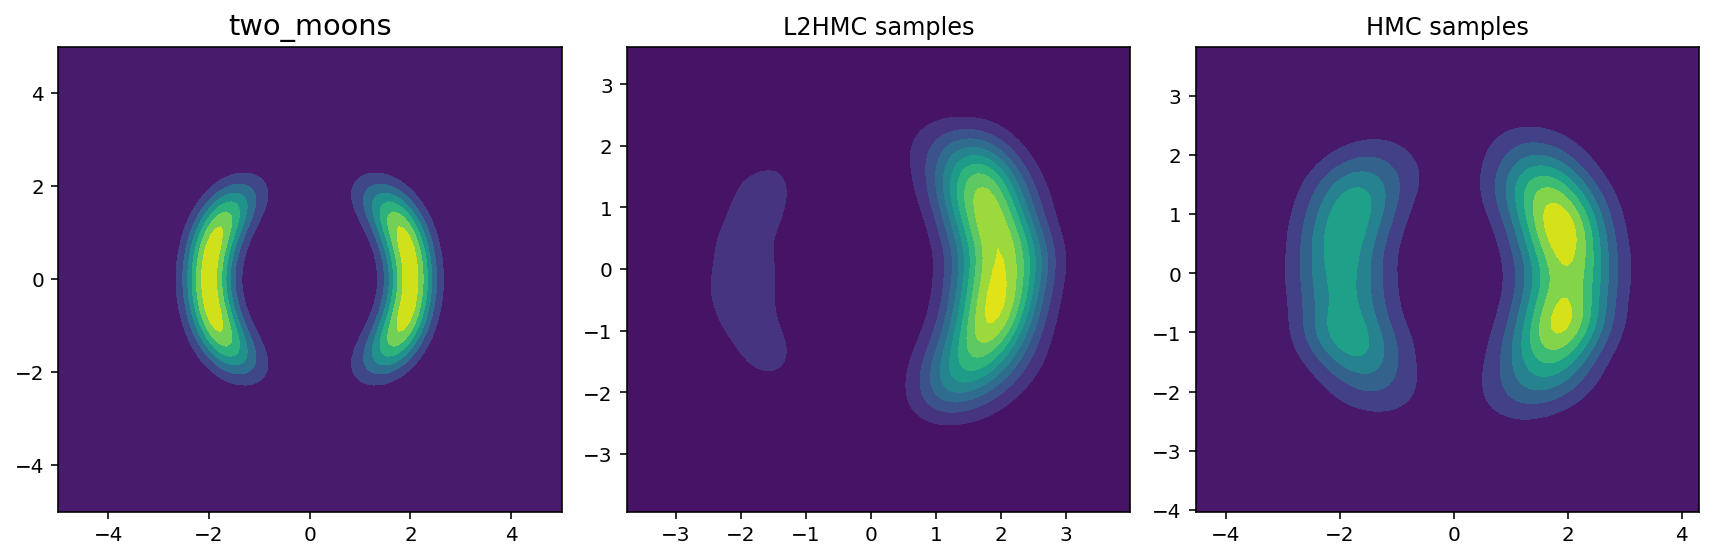

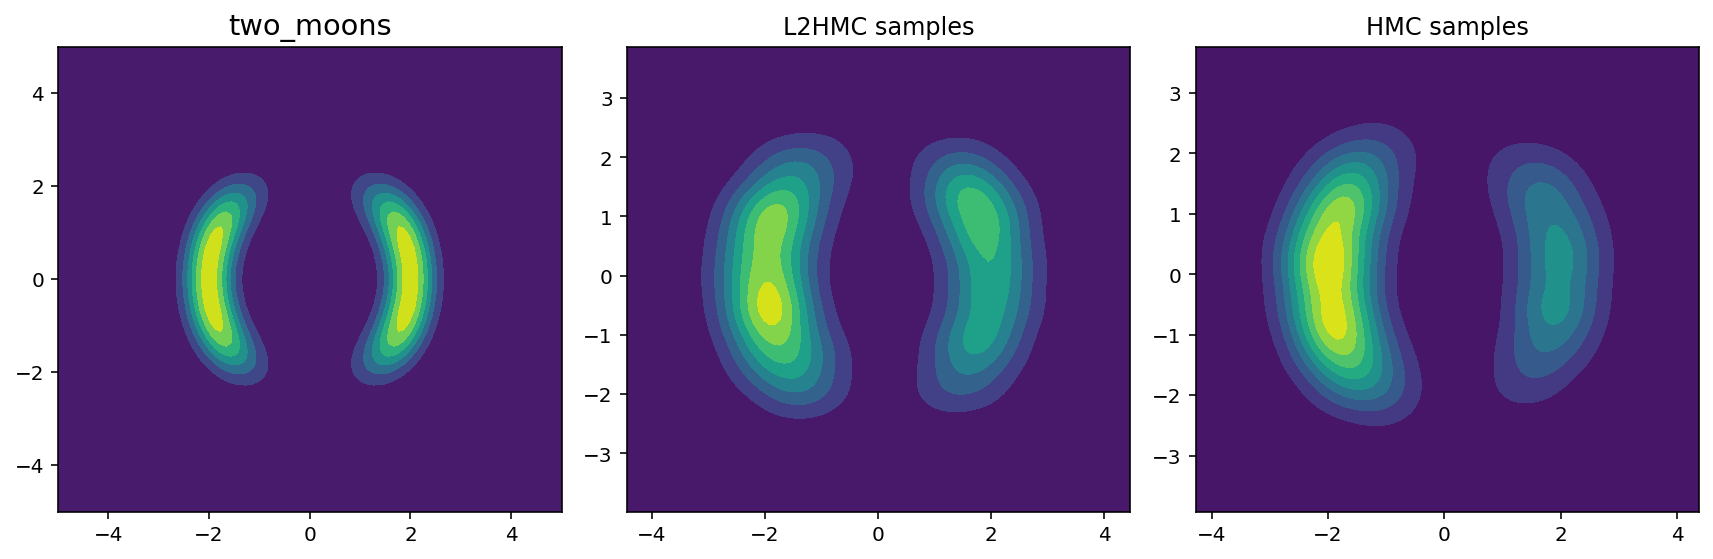

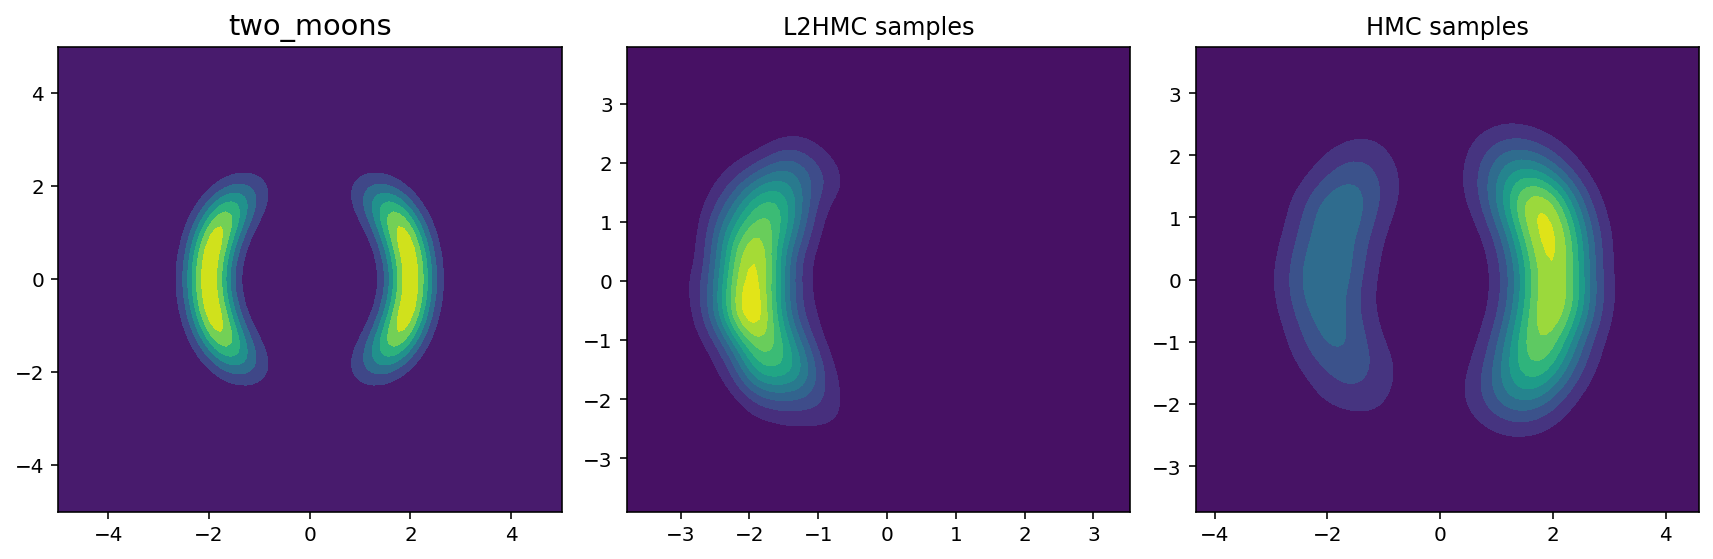

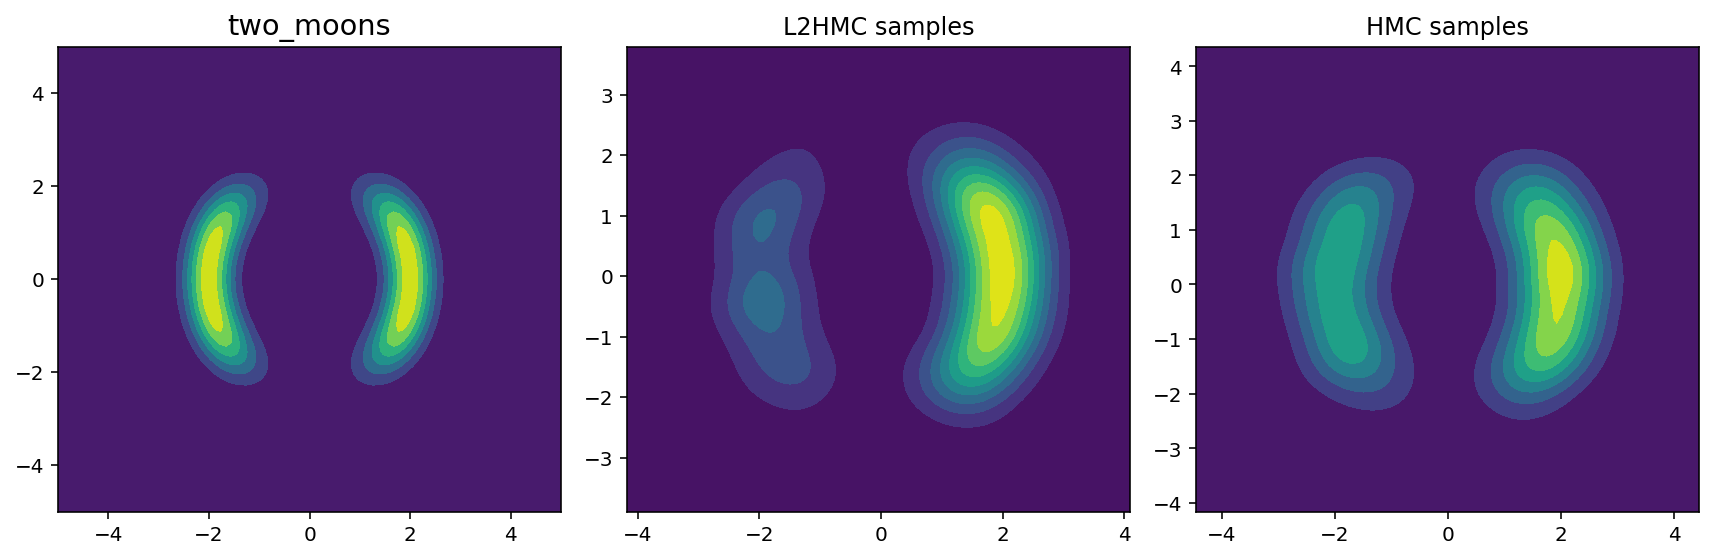

In [21]:
plot_density_estimation(POTENTIAL_FN, x_arr, x_arr_hmc,
                        num_plots=10, title=MODEL_TYPE, cmap='viridis')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

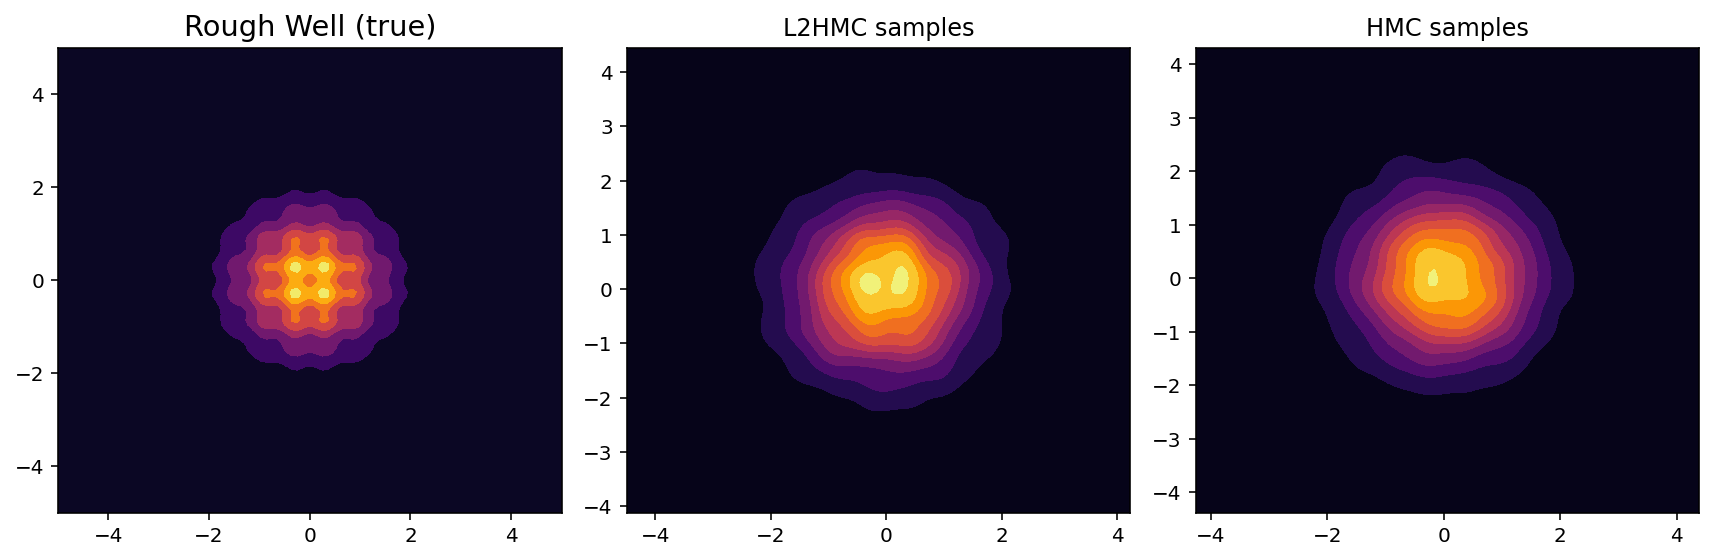

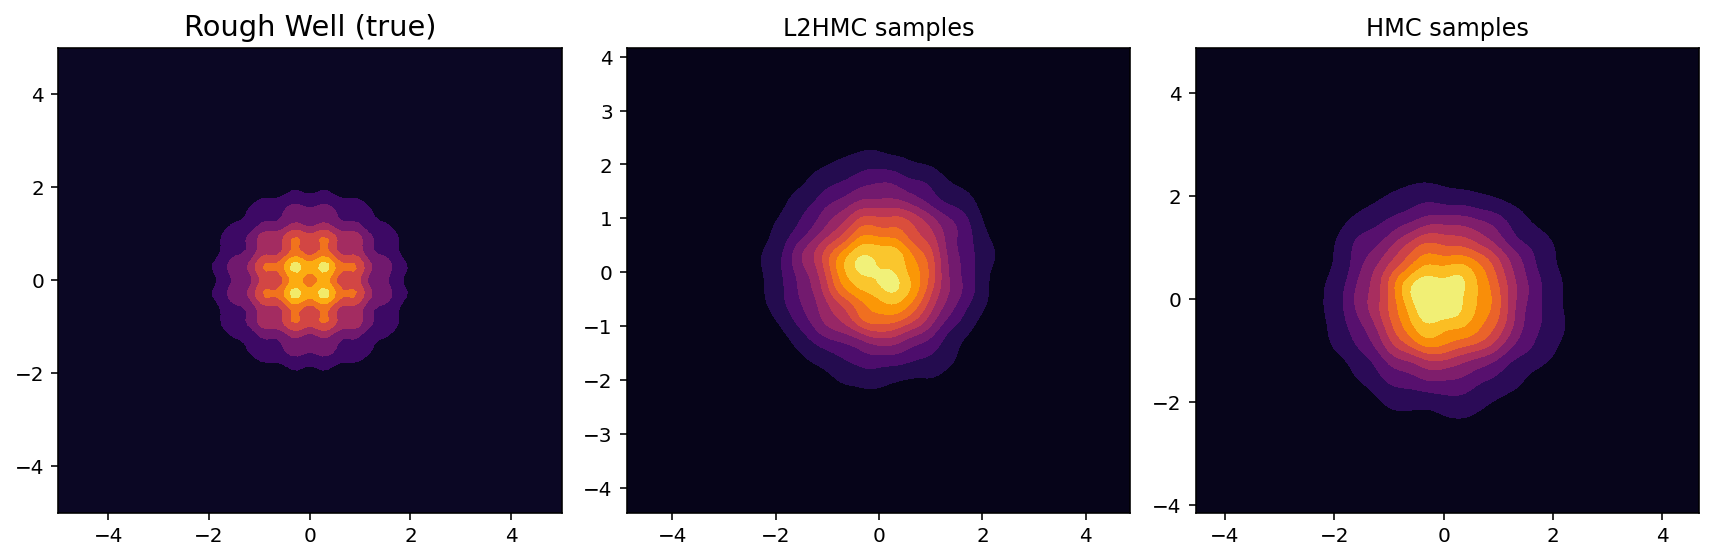

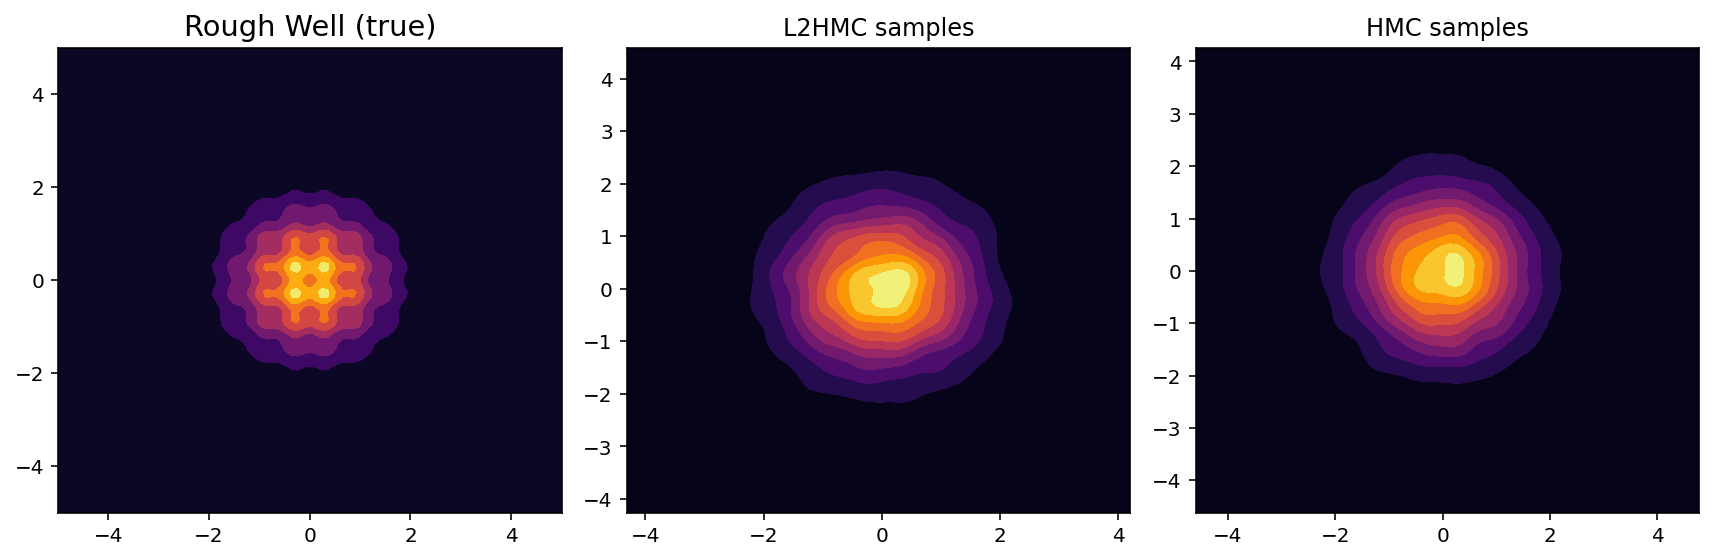

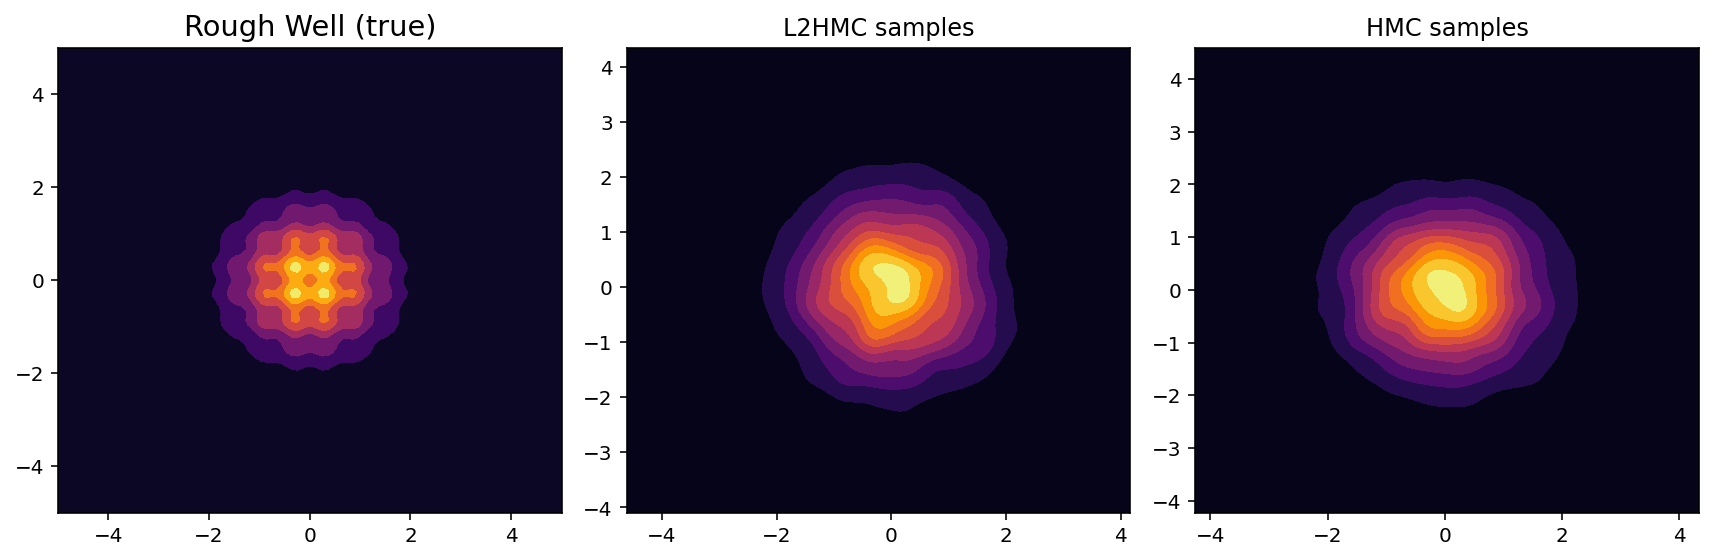

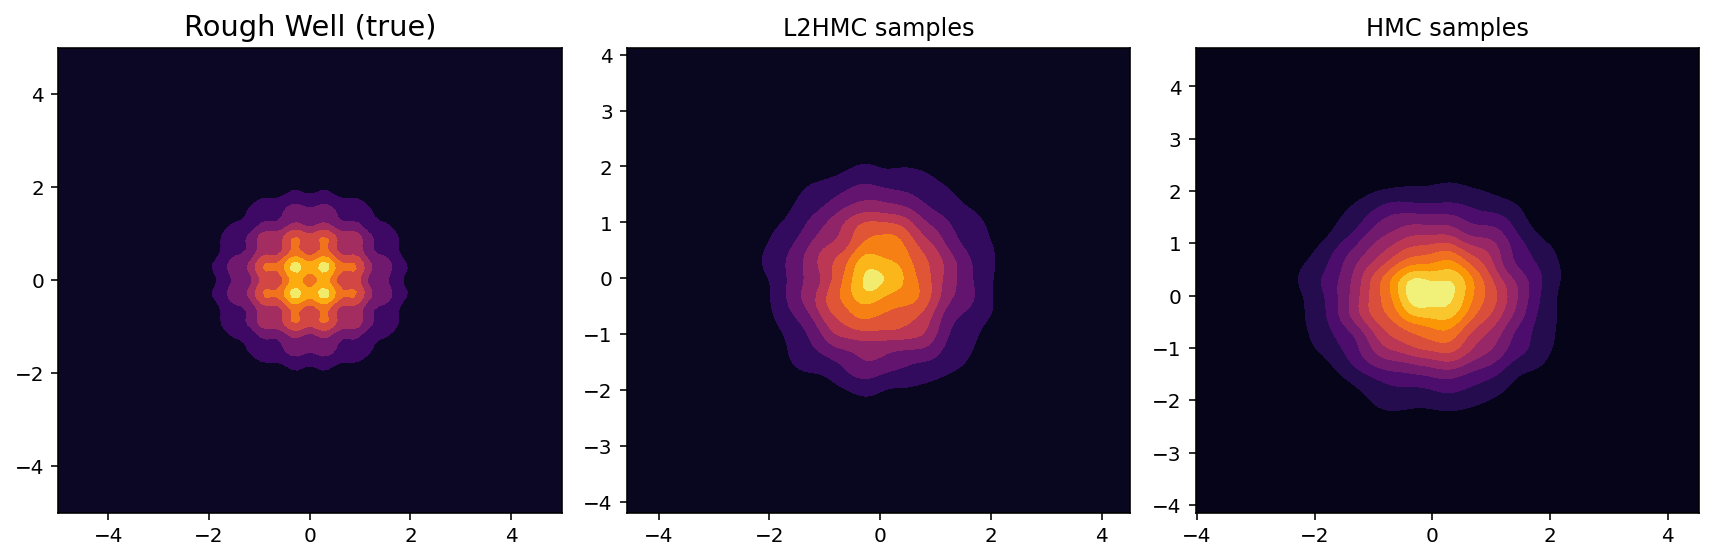

In [77]:
from utils.distributions import contour_potential
xl2hmc = np.array(x_arr)
xhmc = np.array(x_arr_hmc)

for idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    _ = contour_potential(POTENTIAL_FN, title='Rough Well (true)', ax=axes[0])
    _ = sns.kdeplot(xl2hmc[:, idx, 0], xl2hmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[1])
    _ = sns.kdeplot(xhmc[:, idx, 0], xhmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[2])
    _ = axes[1].set_title('L2HMC samples')
    _ = axes[2].set_title('HMC samples')
    plt.tight_layout()

### L2HMC Samples:

2020-08-31 14:43:10,703:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures
Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


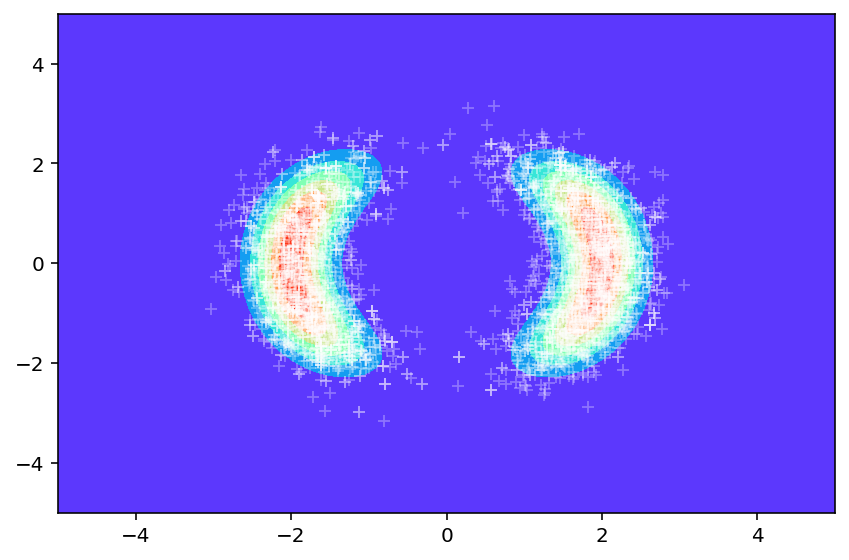

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


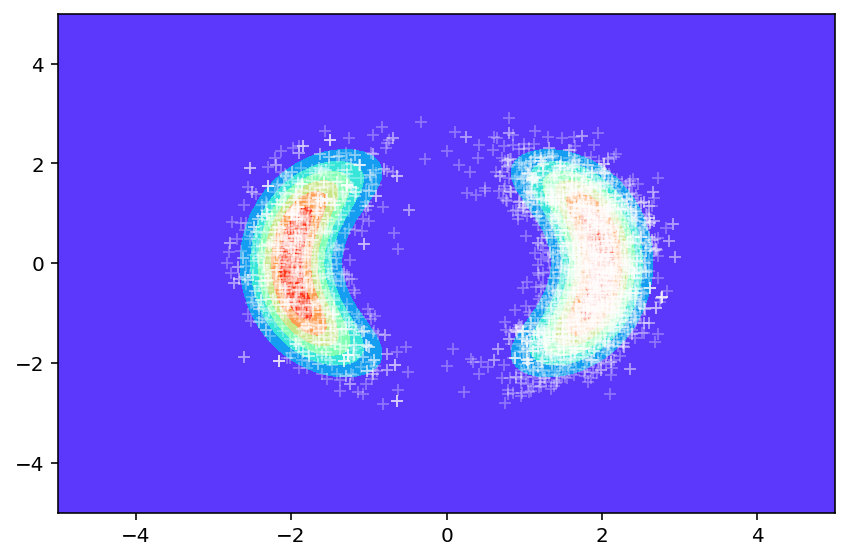

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


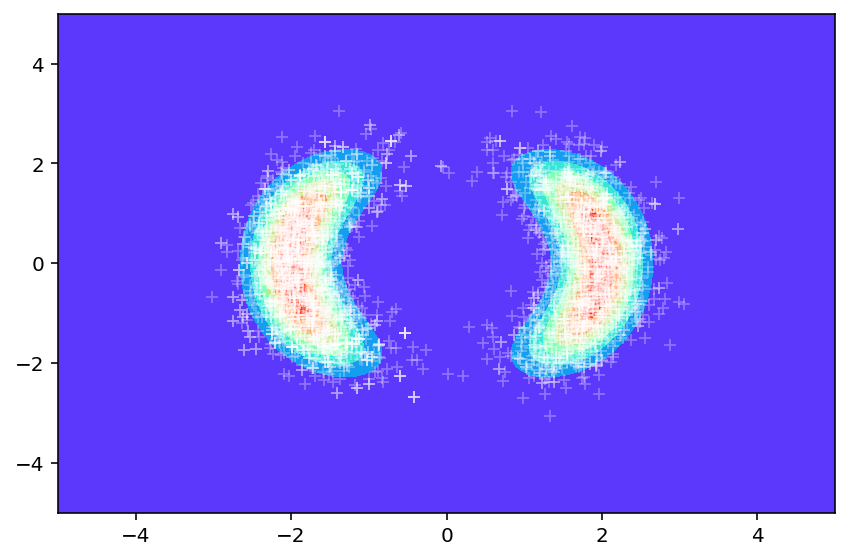

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


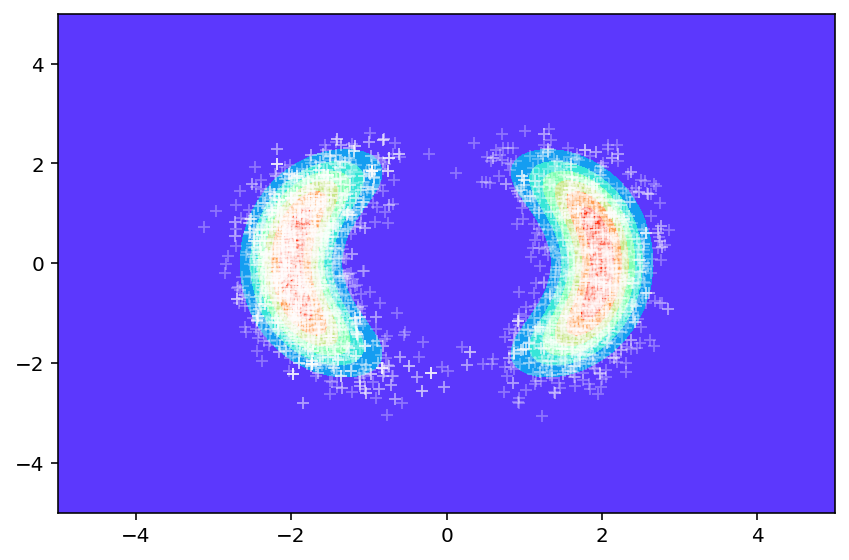

In [19]:
plot_chains(dirs, x_arr, POTENTIAL_FN, label='l2hmc samples', cmap='inferno')

### HMC Samples:

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


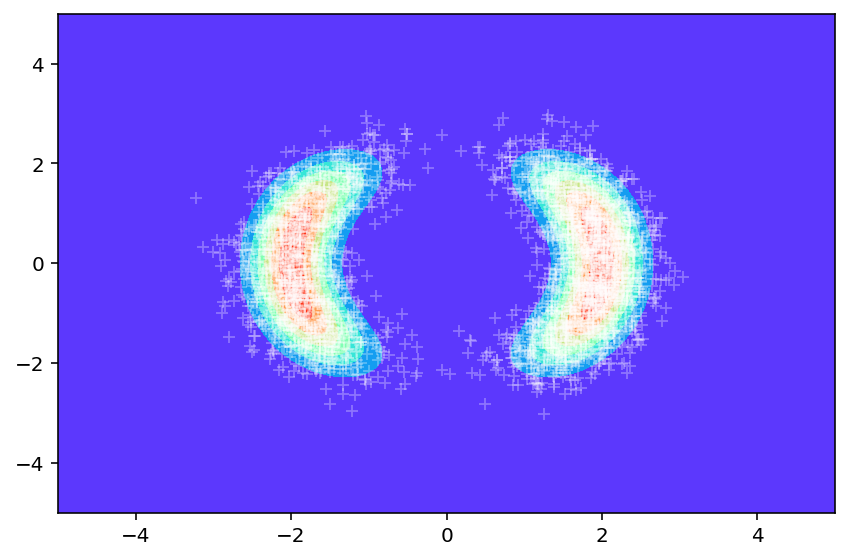

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


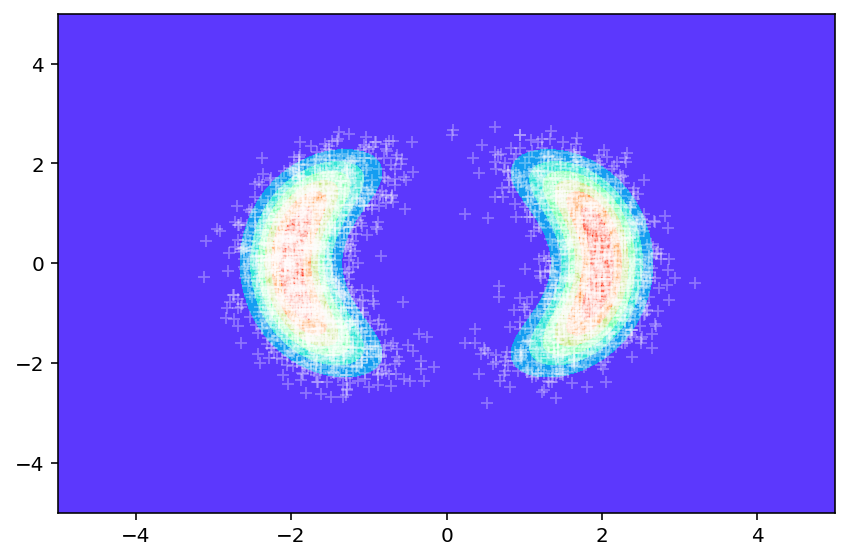

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


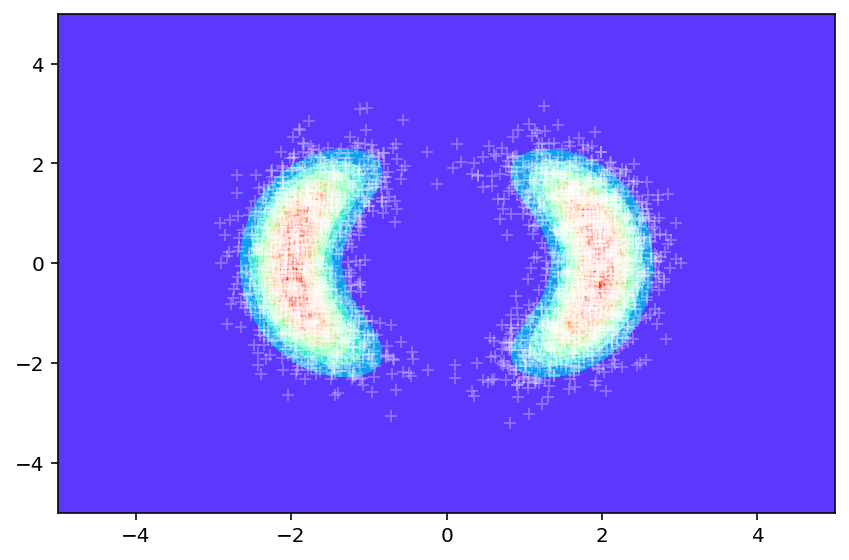

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


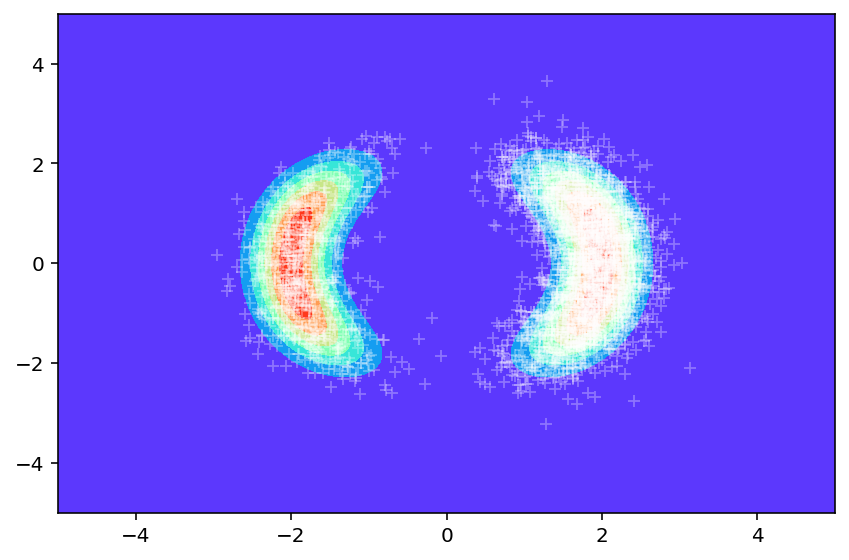

In [20]:
plot_chains(hmc_dirs, x_arr_hmc, POTENTIAL_FN, label='HMC samples', cmap='inferno')